Data taken from : 

- https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals/data (not used)

- https://www.kaggle.com/competitions/playground-series-s3e24/overview

About Dataset
Smoking has been proven to negatively affect health in a multitude of ways.Smoking has been found to harm nearly every organ of the body, cause many diseases, as well as reducing the life expectancy of smokers in general. As of 2018, smoking has been considered the leading cause of preventable morbidity and mortality in the world, continuing to plague the world’s overall health.

According to a World Health Organization report, the number of deaths caused by smoking will reach 10 million by 2030.

Evidence-based treatment for assistance in smoking cessation had been proposed and promoted. however, only less than one third of the participants could achieve the goal of abstinence. Many physicians found counseling for smoking cessation ineffective and time-consuming, and did not routinely do so in daily practice. To overcome this problem, several factors had been proposed to identify smokers who had a better chance of quitting, including the level of nicotine dependence, exhaled carbon monoxide (CO) concentration, cigarette amount per day, the age at smoking initiation, previous quit attempts, marital status, emotional distress, temperament and impulsivity scores, and the motivation to stop smoking. However, individual use of these factors for prediction could lead to conflicting results that were not straightforward enough for the physicians and patients to interpret and apply. Providing a prediction model might be a favorable way to understand the chance of quitting smoking for each individual smoker. Health outcome prediction models had been developed using methods of machine learning over recent years.

A group of scientists are working on predictive models with smoking status as the prediction target.Your task is to help them create a machine learning model to identify the smoking status of an individual using bio-signals

Dataset Description

| Feature | Description |
| --- | --- |
| age | 5-year intervals |
| height (cm) | Height in centimeters |
| weight (kg) | Weight in kilograms |
| waist (cm) | Waist circumference |
| eyesight (left) | Vision (left eye) |
| eyesight (right) | Vision (right eye) |
| hearing (left) | Hearing (left ear) |
| hearing (right) | Hearing (right ear) |
| systolic | Systolic blood pressure |
| relaxation | Diastolic (relaxation) blood pressure |
| fasting blood sugar | Fasting blood sugar |
| Cholesterol | Total cholesterol |
| triglyceride | Triglyceride |
| HDL | High-density lipoprotein cholesterol |
| LDL | Low-density lipoprotein cholesterol |
| hemoglobin | Hemoglobin level |
| Urine protein | Urine protein level |
| serum creatinine | Serum creatinine |
| AST | Glutamic oxaloacetic transaminase |
| ALT | Glutamic pyruvic transaminase |
| Gtp | γ-GTP (Gamma-glutamyl transferase) |
| dental caries | Dental caries (yes/no) |
| smoking | Smoking status (target variable) |


# IMPORTS and LOAD data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from imblearn.over_sampling import SMOTE
from mini_eda_module import mini_eda # https://github.com/andyp14feb/miniEDAtoPDF
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier

from itertools import combinations


df = pd.read_csv('./data/train.csv')
df = df.drop('id', axis=1)


# Function Colloection


## capping_features_based_on_threshold(df, thresholds_df)

In [58]:
def capping_features_based_on_threshold(df, thresholds_df):
    for _, row in thresholds_df.iterrows():
        col = row['feature']
        min_val = row['min']
        max_val = row['max']
        
        flag_col = f"impossibleValue_{col}"
        df[flag_col] = ''
        
        below_flag = f"#{col}_belowMinThreshold; "
        above_flag = f"#{col}_aboveMaxThreshold; "
        
        df.loc[df[col] < min_val, flag_col] += below_flag
        df.loc[df[col] > max_val, flag_col] += above_flag
        
        df[col] = df[col].clip(lower=min_val, upper=max_val)
    
    return df

## calculate_IQR(df, column)

In [59]:
def calculate_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers (data points outside the lower and upper bounds)
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]
    percent_outliers = (num_outliers / len(df)) * 100
    above_upper = df[df[column] > upper_bound].shape[0]
    below_lower = df[df[column] < lower_bound].shape[0]
    
    return lower_bound, upper_bound, num_outliers, percent_outliers, above_upper, below_lower

## clip_values_based_on_IQR(df, column)

In [60]:
def clip_values_based_on_IQR(df, column):
    # Calculate IQR, lower and upper bounds, and outliers
    lower_bound, upper_bound, _, _, _, _ = calculate_IQR(df, column)
    
    # Clip values outside the lower and upper bounds
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

## show_corrMap(pandas_df, savedImageName)

In [ ]:
def show_corrMap(pandas_df, savedImageName):
    df_corr = pandas_df.corr(numeric_only=True)

    # --- create upper-triangle mask to avoid duplicates (optional) ---
    # mask = np.triu(np.ones_like(df_corr, dtype=bool))

    plt.figure(figsize=(11, 9))
    sns.heatmap(
        df_corr,
        # mask=mask,            # comment this line for full matrix
        cmap='coolwarm',
        center=0,
        vmin=-1, vmax=1,
        annot=True,             # <-- numbers on cells
        fmt=".2f",              # 2-decimal format
        annot_kws={"size": 8},  # font size for numbers
        linewidths=.5,
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title('Feature Correlation Matrix (annotated)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(savedImageName, dpi=300)
    plt.show()

## add_combined_features(dfnya)

In [62]:
def add_combined_features(dfnya):
    #kurus/gemuk (ukuran kegemukan)
    dfnya['new_bmi'] = (dfnya['weight_kg'] / (dfnya['height_cm'] ** 2))*100

    #lingkarpinggang (ukuran perut)
    dfnya['new_waist_height_ratio']=dfnya['waist_cm'] / dfnya['height_cm']

    #kekuatan pompa jantung
    dfnya['new_pulse_preasure'] = dfnya['systolic']-dfnya['relaxation']

    #penglihatan_rata-rata
    dfnya['new_vision'] = (dfnya['eyesight_right']+dfnya['eyesight_left'])/2

    #hearing_rata-rata
    dfnya['new_hearing'] = (dfnya['hearing_right']+dfnya['hearing_left'])/2

    #good cholesterol ratio
    dfnya['new_good_chol_ratio'] = (dfnya['hdl'] / dfnya['cholesterol'])*100

    #bad-good cholesterol ratio
    dfnya['new_bad_good_chol_ratio'] = (dfnya['ldl'] / dfnya['hdl'])*100

    #liverEnzimeRatio
    dfnya['new_liverEnzimeRatio'] = (dfnya['ast'] / dfnya['alt'])*100

    return dfnya


## generate_math_combinations(df, target_column, math_operations=['add', 'mul'])

In [ ]:
def generate_math_combinations_pandas(df, target_column, math_operations=['add', 'mul']):
    """
    Create math-based feature combinations 
    """
    df_new = df.copy()
    numeric_cols = df.select_dtypes(include='number').drop(columns=[target_column]).columns.tolist()

    for col1, col2 in combinations(numeric_cols, 2):
        if 'add' in math_operations:
            df_new[f'{col1}_plus_{col2}'] = df[col1] + df[col2]
        if 'sub' in math_operations:
            df_new[f'{col1}_minus_{col2}'] = df[col1] - df[col2]
        if 'mul' in math_operations:
            df_new[f'{col1}_times_{col2}'] = df[col1] * df[col2]
        if 'div' in math_operations:
            # Avoid divide-by-zero
            df_new[f'{col1}_div_{col2}'] = df[col1] / df[col2].replace(0, 1e-6)

    return df_new


## calculate_vif(df, target_column='smoking', vif_threshold=5.0)

In [ ]:
def calculate_vif(df, target_column='smoking', vif_threshold=5.0):
    print('entering calculate_vif()')
    # Drop target
    X = df.drop(columns=[target_column])
    # Drop non-numeric columns if any 
    X = X.select_dtypes(include='number')
    
    
    # Standardize features
    print('Standardize features')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Compute VIF
    print('Compute VIF')
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    
    # Sort by VIF descending
    vif_data = vif_data.sort_values(by='VIF', ascending=False).reset_index(drop=True)
    
    print('-------------------------------------------------------------')
    print(vif_data)
    print('-------------------------------------------------------------')
    print("High VIF features (possible multicollinearity):")
    print(vif_data[vif_data['VIF'] > vif_threshold])
    
    return vif_data


## calculate_vif_v2(df, target_column, vif_threshold=5.0)

In [ ]:
def calculate_vif_v2(df, target_column, vif_threshold=5.0):
   
    print('entering calculate_vif()')
    # Work on a copy of the feature set (drop the target column)
    X = df.drop(columns=[target_column]).copy()
    dropped_features = []

    while True:
        # Calculate VIF
        print('Calculate VIF')
        vif_data = pd.DataFrame()
        vif_data['feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        # Check the highest VIF
        max_vif = vif_data['VIF'].max()
        if max_vif > vif_threshold:
            feature_to_drop = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
            print(f"📉 Dropping '{feature_to_drop}' with VIF = {max_vif:.2f}")
            X.drop(columns=[feature_to_drop], inplace=True)
            dropped_features.append(feature_to_drop)
        else:
            print("✅ All features now have VIF below threshold.")
            break

    # Final VIF report
    final_vif = pd.DataFrame()
    final_vif['feature'] = X.columns
    final_vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return pd.concat([X, df[[target_column]]], axis=1), dropped_features, final_vif


## remove_highly_correlated_features(df, target_column, threshold=0.7)

In [ ]:

def remove_highly_correlated_features(df, target_column, threshold=0.7):

    dfx = df.copy() 
    removed = []

    while True:
        # Calculate correlation matrix
        corr_matrix = dfx.corr()

        # make absolute value then sort highest to lowest
        high_corr_pairs = (
            corr_matrix
            .abs() 
            .where(~np.eye(len(corr_matrix), dtype=bool))  # mask diagonal
            .stack() # dataframe 2D jadi 1D (semacam di pivot jadi panjang ke bawah feature1, feature2, value)
            .sort_values(ascending=False)
        )

        # Filter corr that above threshold
        high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]
        if high_corr_pairs.empty:
            break  #selesai

        # Pick the highest correlation pair
        feature1, feature2 = high_corr_pairs.index[0]

        # Compare correlation to target
        corr_to_target = corr_matrix[target_column]
        corr1 = abs(corr_to_target.get(feature1, 0))
        corr2 = abs(corr_to_target.get(feature2, 0))
        # Remove the weaker one
        if corr1 < corr2:
            to_remove = feature1
        else:
            to_remove = feature2
        print(f'will remove {to_remove}')
        dfx.drop(columns=to_remove, inplace=True)
        
        removed.append(to_remove)

    return dfx, removed   


## splitting_balancing_scaling(the_df, target_column):

In [67]:
def splitting_balancing_scaling(the_df, target_column, df_name=''):
    # Ensure that index is consistent
    the_df.reset_index(drop=True, inplace=True)

    # SPLITTING
    print(f'Splitting the {df_name}')
    print('-----------------------------------')

    X = the_df.drop(columns=[target_column])
    y = the_df[target_column]

    # Perform train-test split, with stratification for target column
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print("Shape of the_df:", the_df.shape)
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    print("===================================")

    # BALANCING
    print(f'Balancing training data')
    print('-----------------------------------')
    sm = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
    print("Original dataset shape:", X_train.shape, y_train.shape)
    print("Balanced dataset shape:", X_train_balanced.shape, y_train_balanced.shape)
    print(f"Original y_train:\n", y_train.value_counts(normalize=True))
    print(f"Balanced y_train:\n", y_train_balanced.value_counts(normalize=True))
    print("===================================")

    # SCALING
    print(f'Scaling X_train and X_test data')
    print('-----------------------------------')
    scaler = StandardScaler()
    X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)  # Fit and transform for training data
    X_test_scaled = scaler.transform(X_test)  # Only transform for test data

    return X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, scaler

## splitting_balancing_scaling_v2(the_df, target_column):

In [68]:
def splitting_balancing_scaling_v2(the_df, target_column, df_name=''):
    # Ensure that index is consistent
    the_df.reset_index(drop=True, inplace=True)

    # SPLITTING
    print(f'Splitting the {df_name}')
    print('-----------------------------------')

    X = the_df.drop(columns=[target_column])
    y = the_df[target_column]

    # Perform train-test split, with stratification for target column
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print("Shape of the_df:", the_df.shape)
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    print("===================================")

    # BALANCING
    print(f'Balancing training data')
    print('-----------------------------------')
    sm = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
    print("Original dataset shape:", X_train.shape, y_train.shape)
    print("Balanced dataset shape:", X_train_balanced.shape, y_train_balanced.shape)
    print(f"Original y_train:\n", y_train.value_counts(normalize=True))
    print(f"Balanced y_train:\n", y_train_balanced.value_counts(normalize=True))
    print("===================================")

    # SCALING
    print(f'Scaling X_train and X_test data')
    print('-----------------------------------')
    scaler = StandardScaler()
    X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)  # Fit and transform for training data
    X_test_scaled = scaler.transform(X_test)  # Only transform for test data



    #return X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, scaler


    X_train_df =  pd.DataFrame(X_train_balanced_scaled)
    X_train_df.columns = the_df.drop(['smoking'], axis=1).columns
    X_train_df.reset_index(drop=True, inplace=True) 
    y_train_df = pd.Series(y_train_balanced, name='smoking') 
    y_train_df.reset_index(drop=True, inplace=True) 
    df_train = pd.concat([X_train_df, y_train_df], axis=1)



    X_test_df =  pd.DataFrame(X_test_scaled)
    X_test_df.columns = the_df.drop(['smoking'], axis=1).columns
    X_test_df.reset_index(drop=True, inplace=True) 
    y_test_df = pd.Series(y_test, name='smoking') 
    y_test_df.reset_index(drop=True, inplace=True)
    df_test = pd.concat([X_test_df, y_test_df], axis=1)


    print("df_train dataset shape:", df_train.shape)
    print("df_test dataset shape:", df_test.shape)

    return X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, scaler , df_train , df_test


## drop_column_if_exists(df, column_name)

In [69]:
def drop_column_if_exists(df, column_name):
    if column_name in df.columns:
        df.drop([column_name], axis=1, inplace=True)
        print(f"Column '{column_name}' dropped successfully.")
    else:
        print(f"Column '{column_name}' does not exist.")    
    return df

## drop_new_feature_yg_lemah_atau_feature_originalnya(df,listnya)

In [ ]:
def drop_new_feature_yg_lemah_atau_feature_originalnya(df,listnya):
    # fungsi ini membandingkan 2 feature pembentuk feature baru 
    # listnya adalah list dengan urutan FeatureLama1, FeatureLama2, FeatureBentukanBaru
    # jika feature baru justru lebih lemah maka feature baru dibuang saja (gak jadi dipakai)
    # jika feature baru paling tinggi , maka feature lama keduanya dibuang
    # jika salah satu feature saja yang lebih lemah dari feature baru, maka feature lemah itu yang dibuang

    corrnya=df.corr(numeric_only=True).loc['smoking', listnya]
    corrnya = corrnya.abs()
    print(f'{corrnya}\nthe lowest value => {corrnya.idxmin()} = {corrnya.min()}')
    if corrnya.idxmax() == listnya[2]:
        #drop original feature if new feature have bigger corr with target
        df=drop_column_if_exists(df,listnya[0])
        df=drop_column_if_exists(df,listnya[1])
    else:
        #drop only the weakest coor with targeet
        df=drop_column_if_exists(df,corrnya.idxmin())

    print('\n\n-------------------------------\n\n')    
    return df

## save_model(model, filename)

In [71]:
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

## load_model(filename)

In [72]:
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model    

## load_model_and_predict(model_file_path,model_file_name, X_test_scaled,y_test)

In [ ]:
def load_model_and_predict(model_file_path,model_file_name, X_test,y_test):
    try:
        model = load_model(f'{model_file_path}{model_file_name}')
        y_pred = model.predict(X_test)
        print(f"== {model_file_name} ==")
        print(classification_report(y_test, y_pred))
        
    except ValueError as ve:
        print(f"ValueError: There was a mismatch in the data or model. Error details: {ve}")
    except AttributeError as ae:
        print(f"AttributeError: The model might be incompatible with the provided data. Error details: {ae}")
    except Exception as e:
        print(f"Unexpected error during prediction: {e}")

## hyper_parameter_tuning_LogisticReg_gridSearch_recall(X_train, y_train)

In [74]:
def hyper_parameter_tuning_LogisticReg_gridSearch_recall(X_train, y_train):

    # Parameter grid
    logreg_param_grid = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear'],
        'clf__fit_intercept': [True, False],
        # 'clf__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
        'clf__class_weight': [None, 'balanced']
    }

    # Pipeline (with class_weight)
    logreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])

    # Custom scorer
    recall_scorer = make_scorer(recall_score, pos_label=1)

    # GridSearchCV
    logreg_grid = GridSearchCV(logreg_pipeline,
                            param_grid=logreg_param_grid,
                            scoring=recall_scorer,
                            cv=5,
                            verbose=1,
                            n_jobs=-1)

    logreg_grid.fit(X_train, y_train)

    best_logreg_model = logreg_grid.best_estimator_
    best_logreg_param = logreg_grid.best_params_
    print("Logistic Regression ; Grid Search ")
    
    print("Best Parameters:")
    for key, value in  logreg_grid.best_params_.items():
        print(f"{key}: {value}")
    
    print("--------------------------------------------")
    return best_logreg_model ,best_logreg_param

## hyper_parameter_tuning_LogisticReg_gridSearch_accuracy(X_train, y_train)

In [75]:
def hyper_parameter_tuning_LogisticReg_gridSearch_accuracy(X_train, y_train):
    # Parameter grid
    logreg_param_grid = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear'],
        'clf__fit_intercept': [True, False],
        # 'clf__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}] kalau data sudah balanced tidak butuh ini
        'clf__class_weight': [None, 'balanced']
        
    }

    # Pipeline
    logreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    # Use accuracy as scoring metric
    accuracy_scorer = make_scorer(accuracy_score)

    # GridSearchCV
    logreg_grid = GridSearchCV(
        estimator=logreg_pipeline,
        param_grid=logreg_param_grid,
        scoring=accuracy_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    logreg_grid.fit(X_train, y_train)

    best_logreg_model = logreg_grid.best_estimator_
    best_logreg_param = logreg_grid.best_params_

    print("Logistic Regression ; Grid Search (Accuracy Focused)")
    print("Best Parameters:")
    for key, value in best_logreg_param.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")

    return best_logreg_model, best_logreg_param


## hyper_parameter_tuning_LogisticReg_gridSearch_AUC(X_train, y_train)

In [ ]:

def hyper_parameter_tuning_LogisticReg_gridSearch_AUC(X_train, y_train):
    logreg_param_grid = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear'],  # 'liblinear' supports both l1 and l2
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced']
    }

    logreg_pipeline = Pipeline([
        # ('scaler', StandardScaler()),  # no need if data already scaled
        ('clf', LogisticRegression(max_iter=1000))
    ])

    logreg_grid = GridSearchCV(
        estimator=logreg_pipeline,
        param_grid=logreg_param_grid,
        scoring='roc_auc',  # Fokus ke AUC
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    logreg_grid.fit(X_train, y_train)

    best_logreg_model = logreg_grid.best_estimator_
    best_logreg_param = logreg_grid.best_params_

    print("Logistic Regression ; Grid Search (AUC Focused)")
    print("Best Parameters:")
    for key, value in best_logreg_param.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")

    return best_logreg_model, best_logreg_param


## hyper_parameter_tuning_randomForest_randomSearch_recall(X_train, y_train)

| Parameter           | Description                                        |
| ------------------- | -------------------------------------------------- |
| `n_estimators`      | Number of trees in the forest                      |
| `max_depth`         | Maximum depth of each tree                         |
| `min_samples_split` | Minimum samples required to split a node           |
| `min_samples_leaf`  | Minimum samples at a leaf node                     |
| `max_features`      | Number of features to consider at each split       |
| `class_weight`      | Helps to boost recall for class 1 (same as before) |


In [77]:
def hyper_parameter_tuning_randomForest_randomSearch_recall(X_train, y_train):

    # Parameter search space
    rf_param_grid = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__max_depth': [None, 10, 20, 30, 40],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2'],
        # 'clf__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
        'clf__class_weight': [None, 'balanced']
    }

    # Create pipeline
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    # Focus on recall for class 1
    recall_scorer = make_scorer(recall_score, pos_label=1)

    # RandomizedSearchCV
    rf_search = RandomizedSearchCV(rf_pipeline,
                                    param_distributions=rf_param_grid,
                                    n_iter=50,
                                    scoring=recall_scorer,
                                    cv=5,
                                    verbose=1,
                                    n_jobs=-1,
                                    random_state=42)

    rf_search.fit(X_train, y_train)

    best_randomForest_model = rf_search.best_estimator_
    best_randomForest_param = rf_search.best_params_
    print("Random Forest ; Random Search ")
    print("Best Parameters:", best_randomForest_param)

    print("Best Parameters:")
    for key, value in  best_randomForest_param.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")

    return best_randomForest_model ,best_randomForest_param


## hyper_parameter_tuning_randomForest_randomSearch_accuracy(X_train, y_train)

In [78]:
def hyper_parameter_tuning_randomForest_randomSearch_accuracy(X_train, y_train):
    # Parameter search space
    rf_param_grid = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__max_depth': [None, 10, 20, 30, 40],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2'],
        # 'clf__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
        'clf__class_weight': [None, 'balanced']

    }

    # Create pipeline
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    # Accuracy scoring
    accuracy_scorer = make_scorer(accuracy_score)

    # RandomizedSearchCV
    rf_search = RandomizedSearchCV(
        estimator=rf_pipeline,
        param_distributions=rf_param_grid,
        n_iter=50,
        scoring=accuracy_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    rf_search.fit(X_train, y_train)

    best_randomForest_model = rf_search.best_estimator_
    best_randomForest_param = rf_search.best_params_

    print("Random Forest ; Random Search (Accuracy Focused)")
    print("Best Parameters:")
    for key, value in best_randomForest_param.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")

    return best_randomForest_model, best_randomForest_param


## hyper_parameter_tuning_randomForest_randomSearch_AUC(X_train, y_train)

In [79]:
def hyper_parameter_tuning_randomForest_randomSearch_AUC(X_train, y_train):
    rf_param_grid = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__max_depth': [None, 10, 20, 30, 40],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__class_weight': [None, 'balanced']
    }

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    rf_search = RandomizedSearchCV(
        rf_pipeline,
        param_distributions=rf_param_grid,
        n_iter=50,
        scoring='roc_auc',  # GANTI di sini
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    rf_search.fit(X_train, y_train)

    best_model = rf_search.best_estimator_
    best_params = rf_search.best_params_
    print("Random Forest ; Random Search (AUC Optimized)")
    print("Best Parameters:")
    for k, v in best_params.items():
        print(f"{k}: {v}")
    print("--------------------------------------------")

    return best_model, best_params


## hyper_parameter_tuning_XGB_randomSearch_recall(X_train, y_train)

| Parameter                 | Purpose                                                             |
| ------------------------- | ------------------------------------------------------------------- |
| `n_estimators`            | Number of boosting rounds (trees)                                   |
| `max_depth`               | Controls complexity (overfitting risk if too deep)                  |
| `learning_rate`           | Smaller values = slower, more accurate learning                     |
| `subsample`               | % of samples used per tree (helps generalization)                   |
| `colsample_bytree`        | % of features used per tree                                         |
| `gamma`                   | Minimum loss reduction to make a split (higher = more conservative) |
| `reg_alpha`, `reg_lambda` | L1/L2 regularization (controls overfitting)                         |
| `scale_pos_weight`        | Helps with imbalanced classes — gives class 1 more "push"           |


In [80]:
def hyper_parameter_tuning_XGB_randomSearch_recall(X_train, y_train):
    xgb_param_grid = {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__gamma': [0, 1, 5],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [0.5, 1, 5],
        # 'clf__scale_pos_weight': [1, 2, 3]  # balances positive class (helpful for class 1 recall)
        #clf__scale_pos_weight tidak dibutuhkan kalau data sudah balanced
    }

    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # optional, but safe to include
        ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
    ])

    recall_scorer = make_scorer(recall_score, pos_label=1)

    xgb_random_search = RandomizedSearchCV(xgb_pipeline,
                                    param_distributions=xgb_param_grid,
                                    n_iter=50,
                                    scoring=recall_scorer,
                                    cv=5,
                                    verbose=1,
                                    n_jobs=-1,
                                    random_state=42)
    xgb_random_search.fit(X_train, y_train)
    print("XGBoost ; Random Search ")
    print("Best Parameters:")
    for key, value in  xgb_random_search.best_params_.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")    
    
    return xgb_random_search.best_estimator_ , xgb_random_search.best_params_


##  hyper_parameter_tuning_XGB_randomSearch_accuracy(X_train, y_train)

In [81]:

def hyper_parameter_tuning_XGB_randomSearch_accuracy(X_train, y_train):
    xgb_param_grid = {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__gamma': [0, 1, 5],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [0.5, 1, 5],
        # 'clf__scale_pos_weight': [1, 2, 3] # #clf__scale_pos_weight tidak dibutuhkan kalau data sudah balanced
    }

    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
    ])

    accuracy_scorer = make_scorer(accuracy_score)

    xgb_random_search = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=xgb_param_grid,
        n_iter=50,
        scoring=accuracy_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    xgb_random_search.fit(X_train, y_train)

    print("XGBoost ; Random Search (Accuracy Focused)")
    print("Best Parameters:")
    for key, value in xgb_random_search.best_params_.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")    

    return xgb_random_search.best_estimator_, xgb_random_search.best_params_


## hyper_parameter_tuning_XGB_randomSearch_AUC(X_train, y_train)

In [ ]:
def hyper_parameter_tuning_XGB_randomSearch_AUC(X_train, y_train):
    xgb_param_grid = {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__gamma': [0, 1, 5],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [0.5, 1, 5],
        # 'clf__scale_pos_weight': [1, 2, 3]  # Uncomment if data imbalance is an issue
    }

    xgb_pipeline = Pipeline([
        # ('scaler', StandardScaler()),  # data sudah already scaled
        ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
    ])

    xgb_random_search = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=xgb_param_grid,
        n_iter=50,
        scoring='roc_auc',  # Ganti scoring ke AUC
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    xgb_random_search.fit(X_train, y_train)

    print("XGBoost ; Random Search (AUC Focused)")
    print("Best Parameters:")
    for key, value in xgb_random_search.best_params_.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")    

    return xgb_random_search.best_estimator_, xgb_random_search.best_params_


## add_to_performance_report_comparison( model_name,y_test, y_pred, X_test,listBaru=False,scaler_name='', dataframe_name='',best_params='', tuning_focus='', verbose=False)

In [83]:
def calculate_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    return auc

In [84]:
def add_to_performance_report_comparison( model_name,y_test, y_pred, X_test, listBaru=False,scaler_name='', dataframe_name='',best_params='', tuning_focus='', verbose=False):
    try:
        df_kompilasihasil=pd.read_excel(f'./output/dataframe_kompilasi_hasil_modelling.xlsx', index_col=None)
        df_kompilasihasil = df_kompilasihasil.loc[:, ~df_kompilasihasil.columns.str.startswith('Unnamed')]

    except Exception as e:
        print("Error reading the dataframe_kompilasi_hasil_modelling.xlsx :", str(e))
        df_kompilasihasil = None

    model = load_model(f'./output/{model_name}') # untuk kebutuhan menghitung AUC

    performance = {
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1 Score': [f1_score(y_test, y_pred)],
        'RoC-AuC': [calculate_auc(model, X_test, y_test)],
        'scaler_name': [scaler_name],
        'dataframe_name': [dataframe_name],
        'tuning_focus': [tuning_focus],
        'best_params': [str(best_params)]
    }
    tempDF = pd.DataFrame(performance)
    if verbose :
        print(tempDF)
    
    if listBaru == True:
        result= tempDF
    else:
        if df_kompilasihasil is None:
            result= tempDF
        else:
            result =pd.concat([df_kompilasihasil, tempDF], axis=0)

    result = result.drop_duplicates()
        
    result.to_excel(f'./output/dataframe_kompilasi_hasil_modelling.xlsx', index=False)
    
    return result

## plot_roc_curves_for_each_test(models_with_data: dict):

In [85]:
def plot_roc_curves_for_each_test(models_with_data: dict,savedImageName):
    plt.figure(figsize=(8, 6))

    for name, (model, X_test, y_test) in models_with_data.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            raise ValueError(f"Model '{name}' does not support predict_proba().")

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(savedImageName, dpi=300)
    plt.show()


# EDA , Data Cleansing and Preprocessing

## Create folder for output files

buat tempat untuk menyimpan file output

output files will be used for :

- untuk double checking
- for documentation 
- pickle files from model training result will be used for production


In [86]:
folder_name = 'output'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'output' already exists.


## Info Dasar

In [87]:
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [88]:
df.columns = df.columns.str.replace("(","_",regex=False)
df.columns = df.columns.str.replace(")","",regex=False)
df.columns = df.columns.str.replace(" ","_",regex=False)
df.columns = df.columns.str.lower()
df.columns

Index(['age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'smoking'],
      dtype='object')

In [89]:
daftarKolomOriginal = df.columns
daftarKolomOriginal

Index(['age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'smoking'],
      dtype='object')

In [90]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols

['age',
 'height_cm',
 'weight_kg',
 'waist_cm',
 'eyesight_left',
 'eyesight_right',
 'hearing_left',
 'hearing_right',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'cholesterol',
 'triglyceride',
 'hdl',
 'ldl',
 'hemoglobin',
 'urine_protein',
 'serum_creatinine',
 'ast',
 'alt',
 'gtp',
 'dental_caries',
 'smoking']

In [91]:
df_head = df.head()
df_info = df.dtypes
df_shape = df.shape


In [92]:
df_head

,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,...,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [93]:
df_info

age                      int64
height_cm                int64
weight_kg                int64
waist_cm               float64
eyesight_left          float64
eyesight_right         float64
hearing_left             int64
hearing_right            int64
systolic                 int64
relaxation               int64
fasting_blood_sugar      int64
cholesterol              int64
triglyceride             int64
hdl                      int64
ldl                      int64
hemoglobin             float64
urine_protein            int64
serum_creatinine       float64
ast                      int64
alt                      int64
gtp                      int64
dental_caries            int64
smoking                  int64
dtype: object

In [94]:
df_shape

(159256, 23)

In [95]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,159256.0,44.306626,11.842286,20.0,40.0,40.0,55.0,85.0
height_cm,159256.0,165.266929,8.818970,135.0,160.0,165.0,170.0,190.0
weight_kg,159256.0,67.143662,12.586198,30.0,60.0,65.0,75.0,130.0
waist_cm,159256.0,83.001990,8.957937,51.0,77.0,83.0,89.0,127.0
eyesight_left,159256.0,1.005798,0.402113,0.1,0.8,1.0,1.2,9.9
eyesight_right,159256.0,1.000989,0.392299,0.1,0.8,1.0,1.2,9.9
hearing_left,159256.0,1.023974,0.152969,1.0,1.0,1.0,1.0,2.0
hearing_right,159256.0,1.023421,0.151238,1.0,1.0,1.0,1.0,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.0,121.0,130.0,213.0
relaxation,159256.0,76.874071,8.994642,44.0,70.0,78.0,82.0,133.0


In [96]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah duplikasi: {num_duplicates}")    

Jumlah duplikasi: 0


In [97]:
duplikacted_rows = df[df.duplicated(keep=False)].sort_values(list(df.columns))
print(f"duplikacted_rows:\n{duplikacted_rows}")
duplikacted_rows.to_excel(r'.\output\xls_01_duplicated_rows.xlsx', index=False) # disimpan ke CSV for future checking


duplikacted_rows:
Empty DataFrame
Columns: [age, height_cm, weight_kg, waist_cm, eyesight_left, eyesight_right, hearing_left, hearing_right, systolic, relaxation, fasting_blood_sugar, cholesterol, triglyceride, hdl, ldl, hemoglobin, urine_protein, serum_creatinine, ast, alt, gtp, dental_caries, smoking]
Index: []

[0 rows x 23 columns]


## remove duplcate Row 

In [98]:
df_shape = df.shape
print(f"Shape = {df_shape}")

df.drop_duplicates(inplace=True)

df_shape = df.shape
print(f"Shape after removing duplicates: {df_shape}")


Shape = (159256, 23)
Shape after removing duplicates: (159256, 23)


## check missing value 


In [99]:
df.isnull().any().any()

False

## Mini EDA

In [100]:
mini_eda(df,r'.\output\pdf_01_mini_eda_result.pdf')

[2025-05-11 10:29:44] ==== mini_eda function started ====
[2025-05-11 10:29:44] Columns found: ['age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left', 'eyesight_right', 'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride', 'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast', 'alt', 'gtp', 'dental_caries', 'smoking']
[2025-05-11 10:29:44] --- Processing column: age ---
[2025-05-11 10:29:44] Non-Null: 159256, Missing: 0, Distinct: 18
[2025-05-11 10:29:44] [age] Value counts: {20: 3829, 25: 9140, 30: 11465, 35: 13081, 40: 46691, 45: 18480, 49: 1, 50: 15768, 55: 13446, 58: 2, 60: 19043, 62: 1, 65: 3637, 69: 1, 70: 2229, 75: 1760, 80: 644, 85: 38}
[2025-05-11 10:29:45] [age] Plot saved: mini_eda_images\age_distribution.png
[2025-05-11 10:29:45] --- Processing column: height_cm ---
[2025-05-11 10:29:45] Non-Null: 159256, Missing: 0, Distinct: 14
[2025-05-11 10:29:45] [height_cm] Value counts: {135: 8, 139: 1

## backup original dataframe


In [101]:
df_000_original = df.copy(deep=True)

## capping / flagging by Impossible Values

In [102]:
df = df_000_original.copy(deep=True)

In [103]:
# df.to_excel('./output/xls_02_smokerStatus_check_impossible_value_before.xlsx', index=False)

In [104]:
impossible_thresholds = pd.DataFrame([
    {'feature': 'age', 'min': 0, 'max': 120},
    {'feature': 'height_cm', 'min': 120, 'max': 210},
    {'feature': 'weight_kg', 'min': 35, 'max': 200},
    {'feature': 'waist_cm', 'min': 50, 'max': 150},
    {'feature': 'eyesight_left', 'min': 0.1, 'max': 2.0},
    {'feature': 'eyesight_right', 'min': 0.1, 'max': 2.0},
    {'feature': 'hearing_left', 'min': 0, 'max': 2},
    {'feature': 'hearing_right', 'min': 0, 'max': 2},
    {'feature': 'systolic', 'min': 90, 'max': 180},
    {'feature': 'relaxation', 'min': 60, 'max': 120},
    {'feature': 'fasting_blood_sugar', 'min': 70, 'max': 126},
    {'feature': 'cholesterol', 'min': 125, 'max': 200},
    {'feature': 'triglyceride', 'min': 50, 'max': 150},
    {'feature': 'hdl', 'min': 40, 'max': 100},
    {'feature': 'ldl', 'min': 50, 'max': 130},
    {'feature': 'hemoglobin', 'min': 12.0, 'max': 17.5},
    {'feature': 'urine_protein', 'min': 0, 'max': 4},
    {'feature': 'serum_creatinine', 'min': 0.6, 'max': 1.3},
    {'feature': 'ast', 'min': 8, 'max': 33},
    {'feature': 'alt', 'min': 7, 'max': 56},
    {'feature': 'gtp', 'min': 8, 'max': 61},
    {'feature': 'dental_caries', 'min': 0, 'max': 1},
])

df = capping_features_based_on_threshold(df,impossible_thresholds)

In [105]:
# df.to_excel('./output/xls_03_smokerStatus_check_impossible_value_after.xlsx', index=False)

In [106]:
# mini_eda(df,r'.\output\pdf_02_mini_eda_result_after_cap_threshold.pdf')

## Check Target immbalance

In [107]:
df['smoking'].value_counts(normalize=False)

0    89603
1    69653
Name: smoking, dtype: int64

In [108]:
df['smoking'].value_counts(normalize=True)
#normalize = True (untuk tau distribusi dalam percent, bukan cuma jumlah count nya)

0    0.562635
1    0.437365
Name: smoking, dtype: float64

## boxplots and distribution plots

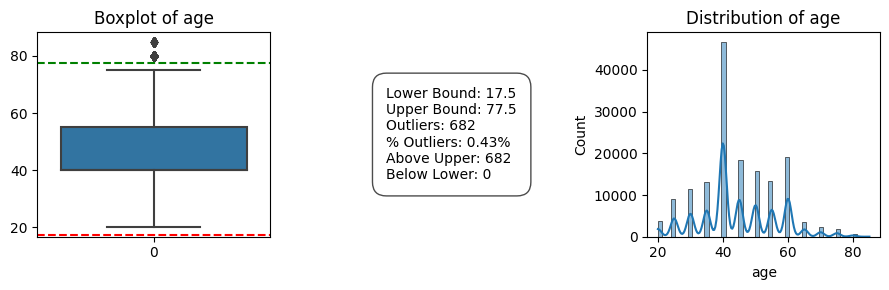

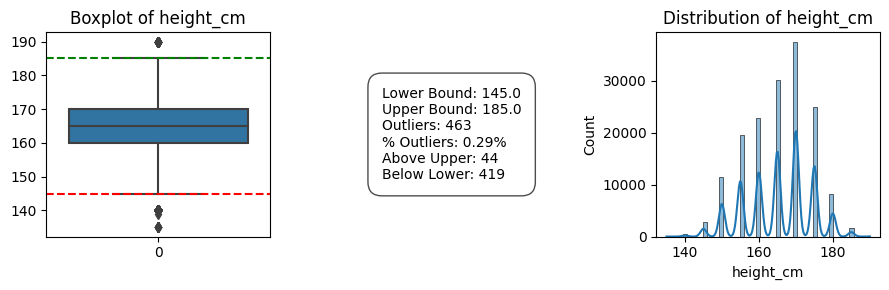

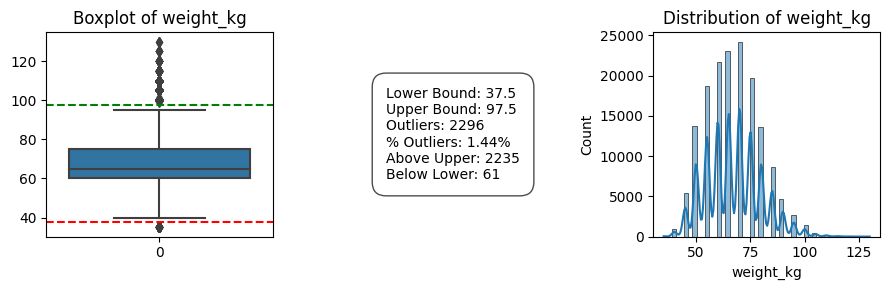

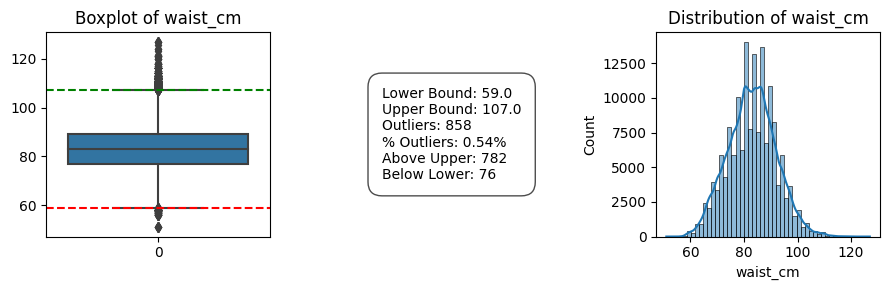

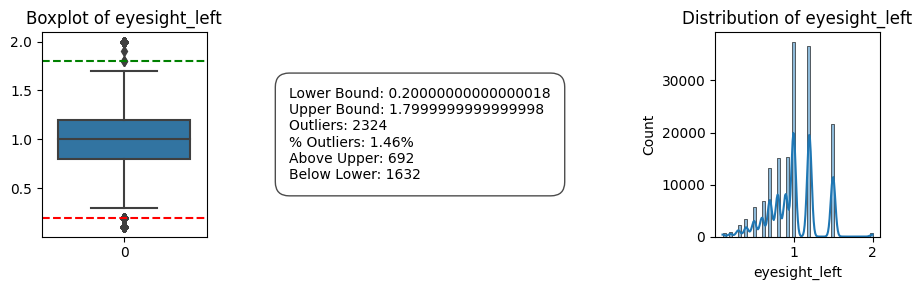

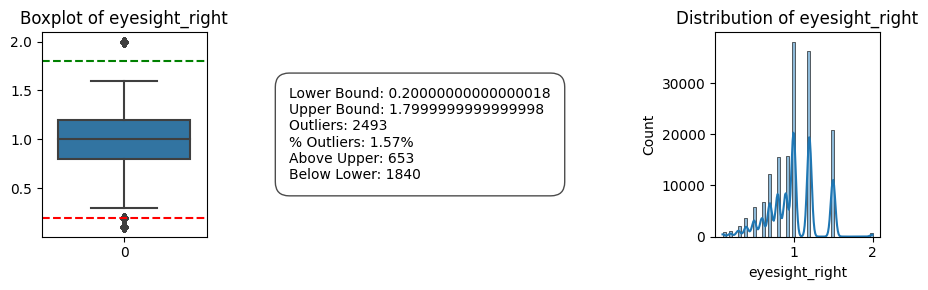

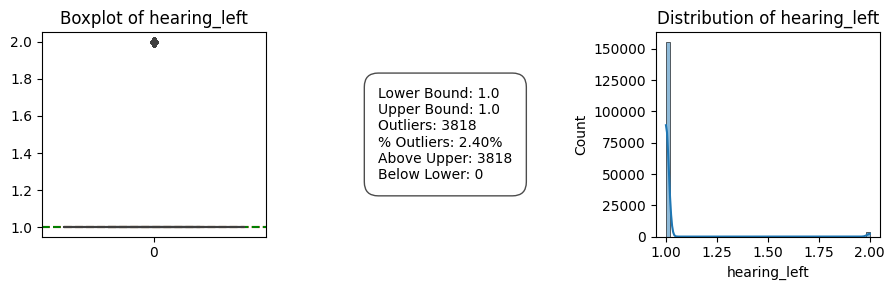

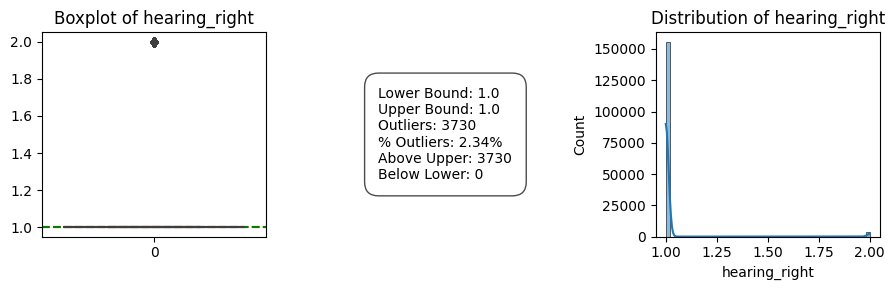

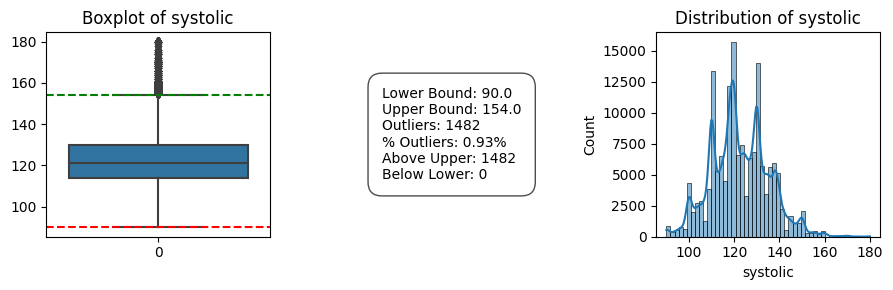

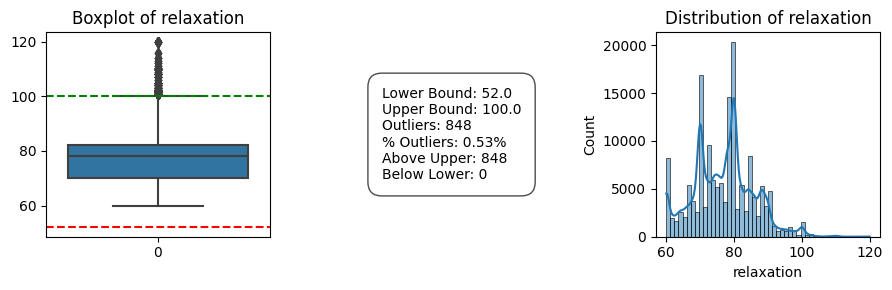

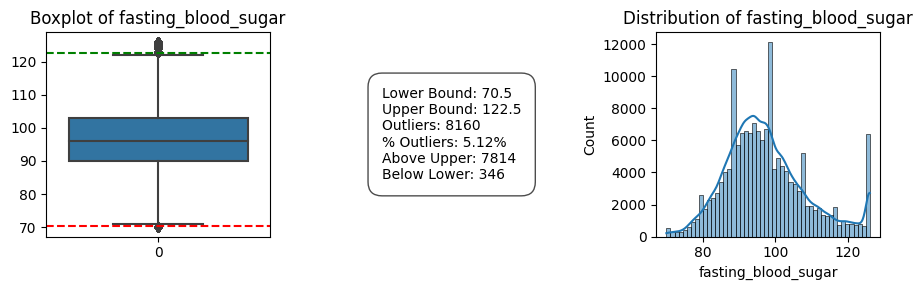

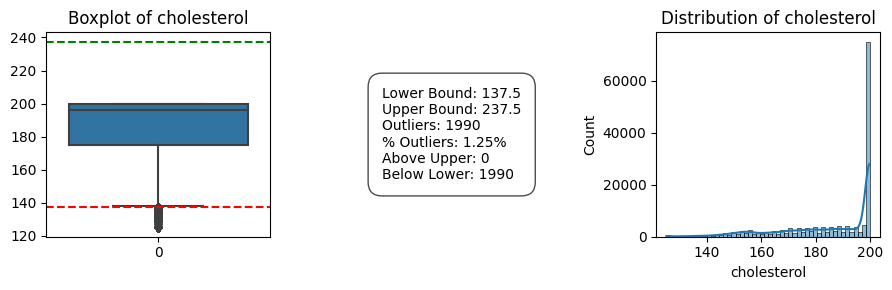

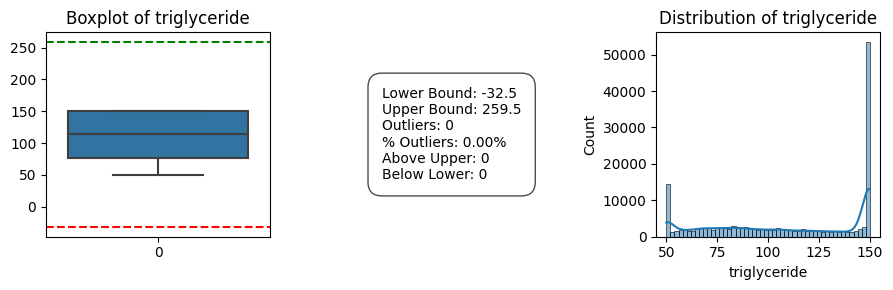

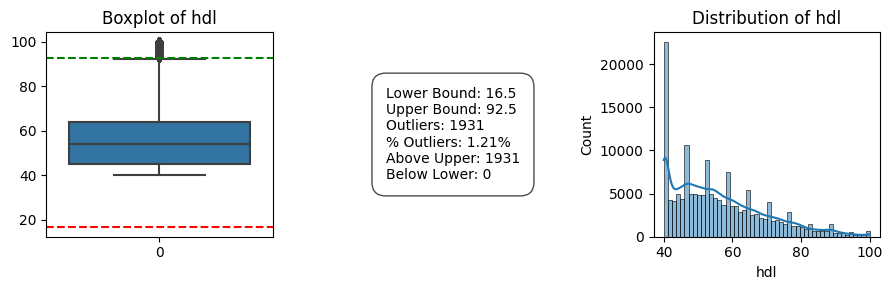

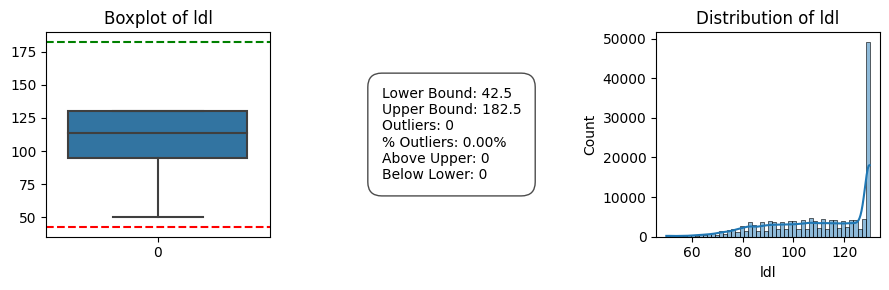

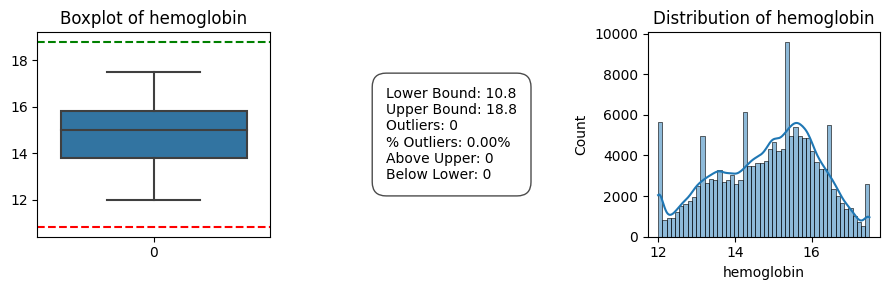

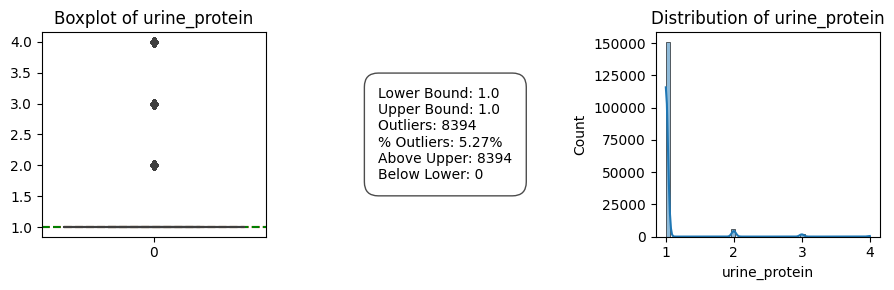

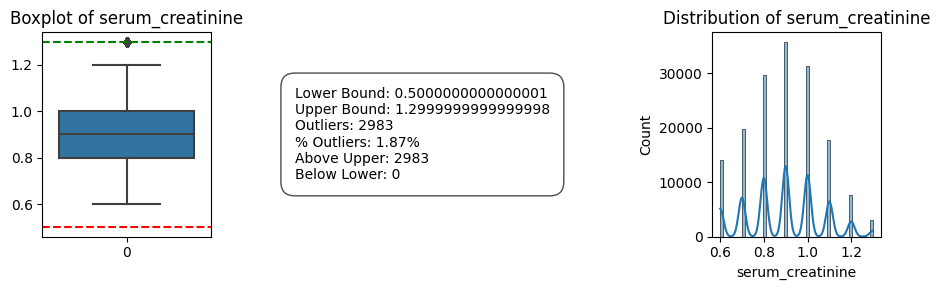

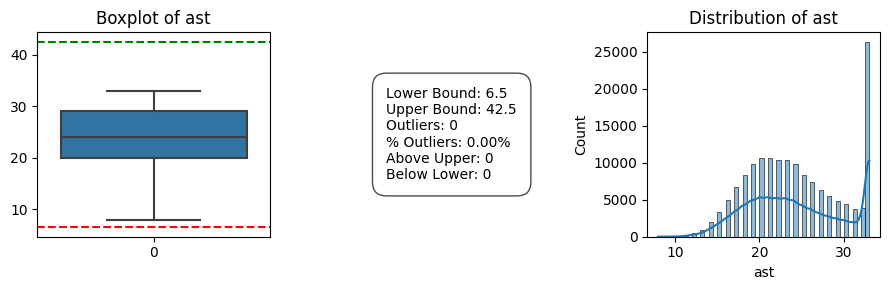

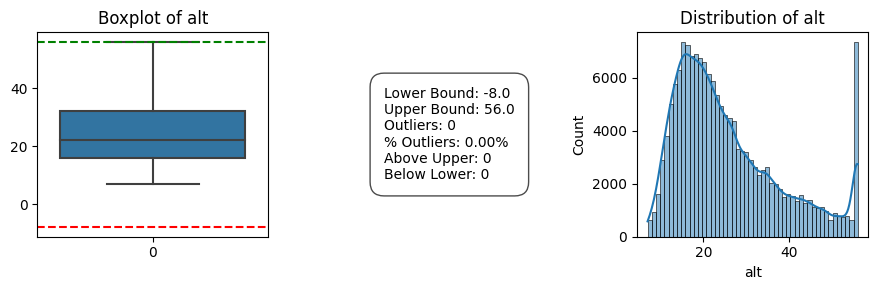

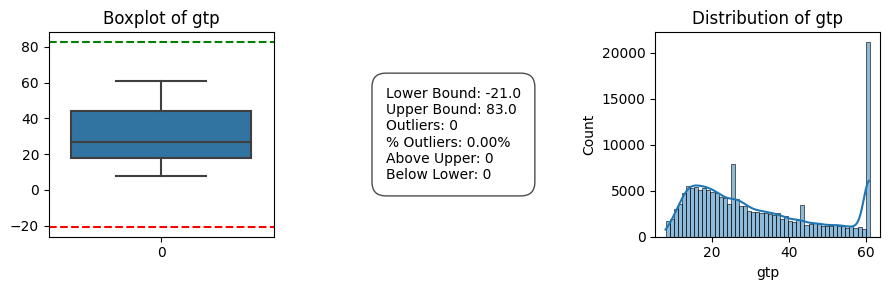

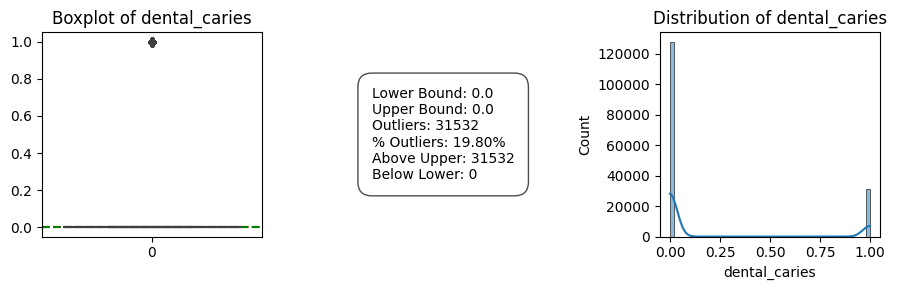

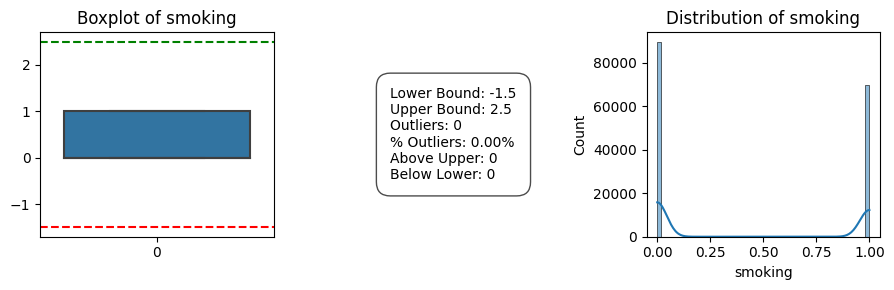

In [109]:
counter = 0
for column in daftarKolomOriginal:
    counter += 1  
    
    if column in df.columns:
        lower_bound, upper_bound, num_outliers, percent_outliers, above_upper, below_lower = calculate_IQR(df, column)
        
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        
        sns.boxplot(data=df[column], ax=axes[0])
        axes[0].set_title(f"Boxplot of {column}")
        axes[0].axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower Bound: {lower_bound}')
        axes[0].axhline(y=upper_bound, color='g', linestyle='--', label=f'Upper Bound: {upper_bound}')
        
        text_str = f"Lower Bound: {lower_bound}\nUpper Bound: {upper_bound}\n" \
                   f"Outliers: {num_outliers}\n% Outliers: {percent_outliers:.2f}%\n" \
                   f"Above Upper: {above_upper}\nBelow Lower: {below_lower}"
        
        axes[0].text(1.5, 0.5, text_str, transform=axes[0].transAxes,
                     fontsize=10, verticalalignment='center', horizontalalignment='left',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=1'))
        
        sns.histplot(df[column], kde=True, bins=50, ax=axes[1])
        axes[1].set_title(f"Distribution of {column}")
        axes[1].set_xlabel(column)
        axes[1].set_ylabel("Count")
        
        plt.tight_layout()
        
        plt.savefig(f'./output/plot_01_boxplot_and_distributionplot_{str(counter).zfill(2)}_of_{column}.jpg', dpi=300)
        
        plt.show()

    else:
        print(f"Column '{column}' not found in the DataFrame.")


## Check for NULL values

In [110]:
df.isnull().any().any()

False

# Balancing before feature Engineering

## add combined feature

In [ ]:
df_M3_step01 = df_000_original.copy(deep=True)
df_M3_step01 = generate_math_combinations_pandas(df_M3_step01,'smoking',['add','mul'])
print(df_M3_step01.shape)
print(df_M3_step01.head)

C:\Users\andyp\AppData\Local\Temp\ipykernel_28356\2659844884.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{col1}_plus_{col2}'] = df[col1] + df[col2]
C:\Users\andyp\AppData\Local\Temp\ipykernel_28356\2659844884.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{col1}_times_{col2}'] = df[col1] * df[col2]
C:\Users\andyp\AppData\Local\Temp\ipykernel_28356\2659844884.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

(159256, 485)
<bound method NDFrame.head of         age  height_cm  weight_kg  waist_cm  eyesight_left  eyesight_right  \
0        55        165         60      81.0            0.5             0.6   
1        70        165         65      89.0            0.6             0.7   
2        20        170         75      81.0            0.4             0.5   
3        35        180         95     105.0            1.5             1.2   
4        30        165         60      80.5            1.5             1.0   
...     ...        ...        ...       ...            ...             ...   
159251   40        155         45      69.0            1.5             2.0   
159252   50        155         75      82.0            1.0             1.0   
159253   40        160         50      66.0            1.5             1.0   
159254   50        165         75      92.0            1.2             1.0   
159255   40        145         45      76.4            1.0             1.2   

        hearing_lef

## Splitting_balancing_scaling 

In [113]:

X_train,y_train, X_test, y_test,M3_scalernya, df_M3_step02_train , df_M3_step02_test = splitting_balancing_scaling_v2(df_M3_step01, 'smoking',df_name ='df_M3_step01' )
save_model(M3_scalernya,f'./output/model_M3_scalernya.pkl')


Splitting the df_M3_step01
-----------------------------------
Shape of the_df: (159256, 485)
Shape of X: (159256, 484)
Shape of y: (159256,)
Shape of X_train: (127404, 484)
Shape of X_test: (31852, 484)
Shape of y_train: (127404,)
Shape of y_test: (31852,)
Balancing training data
-----------------------------------
Original dataset shape: (127404, 484) (127404,)
Balanced dataset shape: (143364, 484) (143364,)
Original y_train:
 0    0.562635
1    0.437365
Name: smoking, dtype: float64
Balanced y_train:
 0    0.5
1    0.5
Name: smoking, dtype: float64
Scaling X_train and X_test data
-----------------------------------
df_train dataset shape: (143364, 485)
df_test dataset shape: (31852, 485)
Model saved to ./output/model_M3_scalernya.pkl


In [114]:
print(df_M3_step01.shape)
print(df_M3_step02_train.shape)
print(df_M3_step02_test.shape)
nan_rows = df_M3_step02_test[df_M3_step02_test.isna().any(axis=1)]
print(nan_rows)

(159256, 485)
(143364, 485)
(31852, 485)
Empty DataFrame
Columns: [age, height_cm, weight_kg, waist_cm, eyesight_left, eyesight_right, hearing_left, hearing_right, systolic, relaxation, fasting_blood_sugar, cholesterol, triglyceride, hdl, ldl, hemoglobin, urine_protein, serum_creatinine, ast, alt, gtp, dental_caries, age_plus_height_cm, age_times_height_cm, age_plus_weight_kg, age_times_weight_kg, age_plus_waist_cm, age_times_waist_cm, age_plus_eyesight_left, age_times_eyesight_left, age_plus_eyesight_right, age_times_eyesight_right, age_plus_hearing_left, age_times_hearing_left, age_plus_hearing_right, age_times_hearing_right, age_plus_systolic, age_times_systolic, age_plus_relaxation, age_times_relaxation, age_plus_fasting_blood_sugar, age_times_fasting_blood_sugar, age_plus_cholesterol, age_times_cholesterol, age_plus_triglyceride, age_times_triglyceride, age_plus_hdl, age_times_hdl, age_plus_ldl, age_times_ldl, age_plus_hemoglobin, age_times_hemoglobin, age_plus_urine_protein, age_

In [115]:
df_M3_step02_train_corr = df_M3_step02_train.corr(numeric_only=True)
# show_corrMap(df_M3_step02_train_corr,'./output/plot_04_correlationMap_df_M3_step02_train_corr.jpg')

## Feature Selection 

In [117]:
df_M3_step02_train.columns

Index(['age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation',
       ...
       'ast_times_gtp', 'ast_plus_dental_caries', 'ast_times_dental_caries',
       'alt_plus_gtp', 'alt_times_gtp', 'alt_plus_dental_caries',
       'alt_times_dental_caries', 'gtp_plus_dental_caries',
       'gtp_times_dental_caries', 'smoking'],
      dtype='object', length=485)

### drop feature yang correlation lemah < 0.05

In [116]:
selection_threshold = 0.05 # correlation threshold

selected_features_prep=df_M3_step02_train_corr['smoking']

selected_features = selected_features_prep[abs(selected_features_prep) > selection_threshold]
selected_feature_names = selected_features.index.to_list()

df_M3_step03_train = df_M3_step02_train[selected_feature_names]
df_M3_step03_train.shape

(143364, 430)

In [118]:
df_M3_step03_train.to_excel(f'./output/df_backup__df_M3_step03_train.xlsx')

## remove feature with high Multicoliniearity

### remove features with high correlation betwen features (>0.75)

remove the one that has weaker correlation with target

In [120]:
print(df_M3_step03_train.shape)
target_column = 'smoking' 
df_M3_step04_train, removed_features = remove_highly_correlated_features(df_M3_step03_train, target_column, threshold=0.7)


(143364, 430)


In [130]:
print(df_M3_step04_train.shape)
print(df_M3_step04_train.columns)
df_M3_step04_train.to_excel(f'./output/df_backup__df_M3_step04_train.xlsx')

(143364, 38)
Index(['age_plus_weight_kg', 'age_plus_hdl', 'age_plus_ldl',
       'age_plus_urine_protein', 'age_times_urine_protein',
       'height_cm_plus_relaxation', 'height_cm_times_hemoglobin',
       'height_cm_plus_ast', 'height_cm_plus_gtp',
       'weight_kg_times_eyesight_left', 'weight_kg_times_eyesight_right',
       'weight_kg_times_hearing_right', 'weight_kg_times_fasting_blood_sugar',
       'weight_kg_times_cholesterol', 'weight_kg_times_urine_protein',
       'eyesight_left_times_eyesight_right', 'eyesight_left_times_hdl',
       'eyesight_left_plus_urine_protein', 'eyesight_left_times_ast',
       'eyesight_right_times_hdl', 'eyesight_right_times_urine_protein',
       'eyesight_right_times_ast', 'eyesight_right_plus_dental_caries',
       'hearing_left_times_hemoglobin', 'hearing_right_times_cholesterol',
       'hearing_right_times_hemoglobin',
       'relaxation_times_fasting_blood_sugar', 'relaxation_plus_ast',
       'fasting_blood_sugar_plus_alt', 'triglyceride

In [122]:
import numpy as np
from IPython.display import Audio, display

def ring_bell(frequency=440, duration=0.2, volume=0.5):
    """
    Play a short beep sound in Jupyter Notebook.
    
    Parameters:
    - frequency (Hz): tone frequency (default: 440Hz)
    - duration (sec): length of the beep (default: 0.2s)
    - volume (0 to 1): volume level (default: 0.5)
    """
    fs = 44100  # sample rate
    t = np.linspace(0, duration, int(fs * duration), False)
    sound = volume * np.sin(2 * np.pi * frequency * t)

    display(Audio(sound, rate=fs, autoplay=True))

### remove features with high VIF Score > 5

In [131]:
df_M3_step04_train, M3_step04_features, VIF_result = calculate_vif_v2(df_M3_step04_train,'smoking', 5)
print(calculate_vif_v2)
print(VIF_result)

📉 Dropping 'age_plus_urine_protein' with VIF = 268.22
📉 Dropping 'eyesight_left_plus_urine_protein' with VIF = 96.31
📉 Dropping 'weight_kg_times_hearing_right' with VIF = 90.56
📉 Dropping 'weight_kg_times_fasting_blood_sugar' with VIF = 61.17
📉 Dropping 'age_plus_ldl' with VIF = 32.51
📉 Dropping 'weight_kg_times_cholesterol' with VIF = 31.18
📉 Dropping 'weight_kg_times_eyesight_right' with VIF = 28.19
📉 Dropping 'age_plus_hdl' with VIF = 22.84
📉 Dropping 'eyesight_left_times_ast' with VIF = 18.08
📉 Dropping 'eyesight_right_plus_dental_caries' with VIF = 15.67
📉 Dropping 'ldl_times_urine_protein' with VIF = 15.16
📉 Dropping 'eyesight_right_times_ast' with VIF = 14.30
📉 Dropping 'weight_kg_times_eyesight_left' with VIF = 11.11
📉 Dropping 'hearing_right_times_cholesterol' with VIF = 9.30
📉 Dropping 'eyesight_right_times_urine_protein' with VIF = 8.15
📉 Dropping 'fasting_blood_sugar_plus_alt' with VIF = 7.12
📉 Dropping 'hdl_times_urine_protein' with VIF = 6.59
✅ All features now have VIF b

In [133]:
df_M3_step04_train.shape

(143364, 21)

In [134]:
df_M3_step04_train.columns

Index(['age_plus_weight_kg', 'age_times_urine_protein',
       'height_cm_plus_relaxation', 'height_cm_times_hemoglobin',
       'height_cm_plus_ast', 'height_cm_plus_gtp',
       'weight_kg_times_urine_protein', 'eyesight_left_times_eyesight_right',
       'eyesight_left_times_hdl', 'eyesight_right_times_hdl',
       'hearing_left_times_hemoglobin', 'hearing_right_times_hemoglobin',
       'relaxation_times_fasting_blood_sugar', 'relaxation_plus_ast',
       'triglyceride_times_alt', 'triglyceride_plus_gtp', 'hdl_times_ldl',
       'serum_creatinine_plus_dental_caries', 'ast_times_gtp',
       'gtp_times_dental_caries', 'smoking'],
      dtype='object')

# Baseline Modelling

In [135]:
# UNCOMENT SALAH SATU BLOK DI BAWAHA INI UNTUK MEMILIH DATA DARI DATA FRAME MANA YANG MAU PAKAI UNTUK MODELLING

#=====================================================
# the_df = df_000_original.select_dtypes(include='number').copy(deep=True)
# nama_dataframe_asal= 'df_000_original_155rb'
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# scaler_name = f'./output/model_{nama_dataframe_asal}_scalernya.pkl'
# save_model(scalernya, f'./output/model_{nama_dataframe_asal}_scalernya.pkl')


# #=====================================================
the_df = df_M3_step04_train.copy(deep=True)
nama_dataframe_asal= 'df_M3_step04_train'
selected_column =list(df_M3_step04_train.columns)

for col in df_M3_step02_test.columns:
    if col not in df_M3_step04_train:
        df_M3_step02_test.drop(columns=col, inplace=True)

X_train = df_M3_step04_train.drop(columns='smoking')
y_train = df_M3_step04_train['smoking']

X_test = df_M3_step02_test.drop(columns='smoking')
y_test = df_M3_step02_test['smoking']
scaler_name = 'model_M3_scalernya.pkl'
# ======================================================================================================



.
.
Model saved to ./output/model_df_M3_step04_train_logreg_basic.pkl
Model loaded from ./output/model_df_M3_step04_train_logreg_basic.pkl
Model loaded from ./output/model_df_M3_step04_train_logreg_basic.pkl
Model saved to ./output/model_df_M3_step04_train_randomForest_basic.pkl
Model loaded from ./output/model_df_M3_step04_train_randomForest_basic.pkl
Model loaded from ./output/model_df_M3_step04_train_randomForest_basic.pkl
Model saved to ./output/model_df_M3_step04_train_xgbost_basic.pkl
Model loaded from ./output/model_df_M3_step04_train_xgbost_basic.pkl
Model loaded from ./output/model_df_M3_step04_train_xgbost_basic.pkl


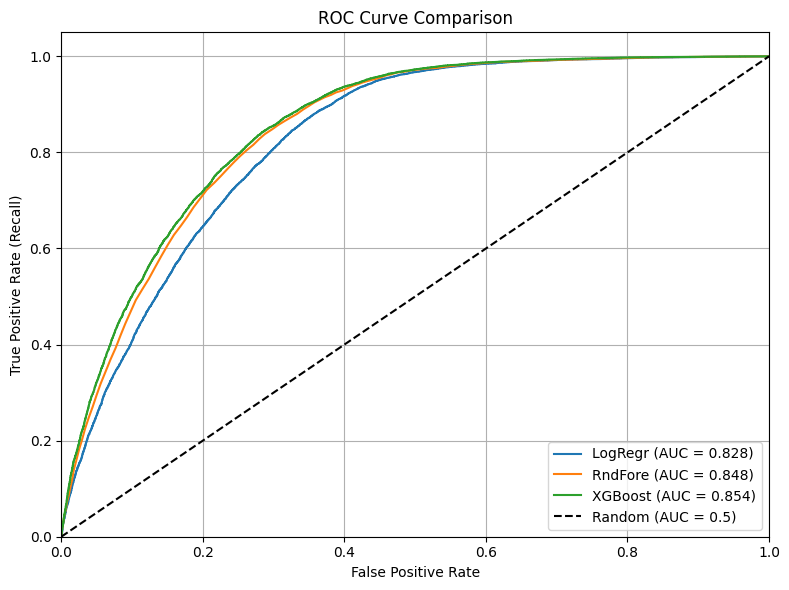

In [ ]:
target_column = 'smoking'

print(f'===================================================')
print(".")
print(".")

# Logistic Regression
modelnya = LogisticRegression()
modelnya.fit(X_train, y_train)
model_name = f'model_{nama_dataframe_asal}_logreg_basic.pkl'
model_file_full_path = f'./output/{model_name}'
save_model(modelnya, model_file_full_path)
model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
# print(f"== {model_name} ==")
# print(classification_report(y_test, y_pred))
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal)

model_logregr=modelnya

# Random Forest Classifier
modelnya = RandomForestClassifier()
modelnya.fit(X_train, y_train)
model_name = f'model_{nama_dataframe_asal}_randomForest_basic.pkl'
model_file_full_path = f'./output/{model_name}'
save_model(modelnya, model_file_full_path)
model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
# print(f"== {model_name} ==")
# print(classification_report(y_test, y_pred))
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal)

model_rndfore=modelnya



# XGBoost Classifier
modelnya = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
modelnya.fit(X_train, y_train)
model_name = f'model_{nama_dataframe_asal}_xgbost_basic.pkl'
model_file_full_path = f'./output/{model_name}'
save_model(modelnya, model_file_full_path) 
model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
# print(f"== {model_name} ==")
# print(classification_report(y_test, y_pred))
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal)

model_xgboost=modelnya



models_with_data = {
    "LogRegr": (model_logregr, X_test, y_test),
    "RndFore": (model_rndfore, X_test, y_test),
    "XGBoost": (model_xgboost, X_test, y_test),
}
plot_roc_curves_for_each_test(models_with_data,f'./output/plot_10_ROC_Curve_model_df_M3_step04_train_gabungan_basic.jpg')

In [ ]:
df_kompilasihasil.sort_values(by='Accuracy', ascending=False)

| **Metric**              | **Why it matters**                                                                                                                                                                                |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Recall (class 1)**    | Measures how many real smokers the model correctly detects. <br>Use when it's critical not to miss any smokers. Example: in medical screening, you want to identify everyone who needs attention. |
| **F1-score (class 1)**  | Combines both precision and recall. <br>Use this when you want a **balanced performance** — not too many false negatives, and not too many false positives.                                       |
| **Precision (class 1)** | Measures how many of the predicted smokers are actually smokers. <br>Use this when **predicting someone as a smoker has serious consequences** (e.g., legal, privacy, or social impact).          |


# Hyper Parameter Tuning (Focus on Recall)

In [ ]:
# UNCOMENT SALAH SATU BLOK DI BAWAHA INI UNTUK MEMILIH DATA DARI DATA FRAME MANA YANG MAU PAKAI UNTUK MODELLING

#=====================================================
# the_df = df_000_original.select_dtypes(include='number').copy(deep=True)
# nama_dataframe_asal= 'df_000_original_155rb'
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# scaler_name = f'./output/model_{nama_dataframe_asal}_scalernya.pkl'
# save_model(scalernya, f'./output/model_{nama_dataframe_asal}_scalernya.pkl')


#=====================================================

the_df = df_M3_step04_train.copy(deep=True)
nama_dataframe_asal= 'df_M3_step04_train'
selected_column =list(df_M3_step04_train.columns)
for col in df_M3_step02_test.columns:
    if col not in df_M3_step04_train:
        df_M3_step02_test.drop(columns=col, inplace=True)
X_train = df_M3_step04_train.drop(columns='smoking')
y_train = df_M3_step04_train['smoking']
X_test = df_M3_step02_test.drop(columns='smoking')
y_test = df_M3_step02_test['smoking']
scaler_name = 'model_M3_scalernya.pkl'
# ======================================================================================================

## GridSearch for Logistic Regression

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_LogisticReg_gridSearch_recall(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_logreg_bestModel_recall.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)


model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for Recall')

## Random Search for Random Forest

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_randomForest_randomSearch_recall(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_randomForest_bestModel_recall.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)

model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for Recall')


## RandomSearch for XGBoost 

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_XGB_randomSearch_recall(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_xgboost_bestModel_recall.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)

model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for Recall')

# Hyper Parameter Tuning (Focuks on Accuracy)

In [ ]:
# UNCOMENT SALAH SATU BLOK DI BAWAHA INI UNTUK MEMILIH DATA DARI DATA FRAME MANA YANG MAU PAKAI UNTUK MODELLING

#=====================================================
# the_df = df_000_original.select_dtypes(include='number').copy(deep=True)
# nama_dataframe_asal= 'df_000_original_155rb'
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# scaler_name = f'./output/model_{nama_dataframe_asal}_scalernya.pkl'
# save_model(scalernya, f'./output/model_{nama_dataframe_asal}_scalernya.pkl')

#=====================================================

the_df = df_M3_step04_train.copy(deep=True)
nama_dataframe_asal= 'df_M3_step04_train'
selected_column =list(df_M3_step04_train.columns)
for col in df_M3_step02_test.columns:
    if col not in df_M3_step04_train:
        df_M3_step02_test.drop(columns=col, inplace=True)
X_train = df_M3_step04_train.drop(columns='smoking')
y_train = df_M3_step04_train['smoking']
X_test = df_M3_step02_test.drop(columns='smoking')
y_test = df_M3_step02_test['smoking']
scaler_name = 'model_M3_scalernya.pkl'
# ======================================================================================================

## GridSearch for Logistic Regression

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_LogisticReg_gridSearch_accuracy(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_logreg_bestModel_Accuracy.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)

model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for Accuracy')

## RandomSearch for RandomForest

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_randomForest_randomSearch_accuracy(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_randomForest_bestModel_Accuracy.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)


model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for Accuracy')

## RandomSearch for XGBoost

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_XGB_randomSearch_accuracy(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_xgboost_bestModel_Accuracy.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)

model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for Accuracy')

# Hyper Parameter Tuning (Focus on AUC)

In [ ]:
# UNCOMENT SALAH SATU BLOK DI BAWAHA INI UNTUK MEMILIH DATA DARI DATA FRAME MANA YANG MAU PAKAI UNTUK MODELLING

#=====================================================
# the_df = df_000_original.select_dtypes(include='number').copy(deep=True)
# nama_dataframe_asal= 'df_000_original_155rb'
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# X_train,y_train, X_test, y_test,scalernya = splitting_balancing_scaling(the_df, target_column, nama_dataframe_asal)
# scaler_name = f'./output/model_{nama_dataframe_asal}_scalernya.pkl'
# save_model(scalernya, f'./output/model_{nama_dataframe_asal}_scalernya.pkl')

#=====================================================

the_df = df_M3_step04_train.copy(deep=True)
nama_dataframe_asal= 'df_M3_step04_train'
selected_column =list(df_M3_step04_train.columns)
for col in df_M3_step02_test.columns:
    if col not in df_M3_step04_train:
        df_M3_step02_test.drop(columns=col, inplace=True)
X_train = df_M3_step04_train.drop(columns='smoking')
y_train = df_M3_step04_train['smoking']
X_test = df_M3_step02_test.drop(columns='smoking')
y_test = df_M3_step02_test['smoking']
scaler_name = 'model_M3_scalernya.pkl'
# ======================================================================================================

## GridSearch for Logistic Regression

In [ ]:
best_model,best_model_params = hyper_parameter_tuning_LogisticReg_gridSearch_AUC(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_logreg_bestModel_AUC.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)

model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for AUC')

In [ ]:
models_with_data = {
    "LogReg": (model, X_test, y_test),
}
plot_roc_curves_for_each_test(models_with_data,f'./output/plot_10_ROC_AUC_Curve_{model_name}.jpg')

In [ ]:
model_logreg=model

## RandomSearch for RandomForest

In [142]:
best_model,best_model_params = hyper_parameter_tuning_randomForest_randomSearch_AUC(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_randomForest_bestModel_AUC.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)


model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for AUC')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest ; Random Search (AUC Optimized)
Best Parameters:
clf__n_estimators: 400
clf__min_samples_split: 2
clf__min_samples_leaf: 1
clf__max_features: log2
clf__max_depth: None
clf__class_weight: None
--------------------------------------------
Model saved to ./output/model_df_M3_step04_train_randomForest_bestModel_AUC.pkl
Model loaded from ./output/model_df_M3_step04_train_randomForest_bestModel_AUC.pkl
Model loaded from ./output/model_df_M3_step04_train_randomForest_bestModel_AUC.pkl


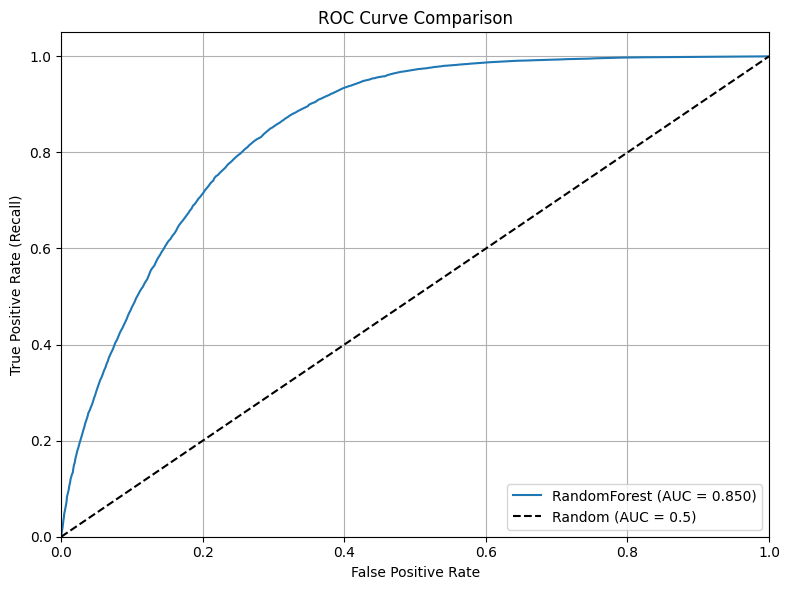

In [143]:
models_with_data = {
    "RandomForest": (model, X_test, y_test),
}
plot_roc_curves_for_each_test(models_with_data,f'./output/plot_10_ROC_AUC_Curve_{model_name}.jpg')

In [ ]:
model_rf=model

## RandomSearch for XGBoost

In [138]:
best_model,best_model_params = hyper_parameter_tuning_XGB_randomSearch_AUC(X_train, y_train)
# best_model.fit(X_train, y_train)

model_name = f'model_{nama_dataframe_asal}_xgboost_bestModel_AUC.pkl'
model_file_full_path = f'./output/{model_name}'

save_model(best_model,model_file_full_path)

model = load_model(model_file_full_path)
y_pred = model.predict(X_test)
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for AUC')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost ; Random Search (AUC Focused)
Best Parameters:
clf__subsample: 1.0
clf__reg_lambda: 0.5
clf__reg_alpha: 1
clf__n_estimators: 300
clf__max_depth: 5
clf__learning_rate: 0.2
clf__gamma: 5
clf__colsample_bytree: 0.6
--------------------------------------------
Model saved to ./output/model_df_M3_step04_train_xgboost_bestModel_AUC.pkl
Model loaded from ./output/model_df_M3_step04_train_xgboost_bestModel_AUC.pkl
Model loaded from ./output/model_df_M3_step04_train_xgboost_bestModel_AUC.pkl


PermissionError: [Errno 13] Permission denied: './output/dataframe_kompilasi_hasil_modelling.xlsx'

In [141]:
df_kompilasihasil=add_to_performance_report_comparison( model_name,y_test, y_pred,X_test,False,scaler_name,nama_dataframe_asal,best_model_params,'Tuned for AUC')

Model loaded from ./output/model_df_M3_step04_train_xgboost_bestModel_AUC.pkl


In [ ]:
models_with_data = {
    "XGBoost": (model, X_test, y_test),
}
plot_roc_curves_for_each_test(models_with_data,f'./output/plot_10_ROC_AUC_Curve_{model_name}.jpg')

In [ ]:
model_xgb=model

In [ ]:
models_with_data = {
    "LogisticReg": (model_logreg, X_test, y_test),
    "RandomForest": (model_rf, X_test, y_test),
    "XGBoost": (model_xgb, X_test, y_test)
}
plot_roc_curves_for_each_test(models_with_data,f'./output/plot_10_ROC_AUC_Curve_Gabungan_AUC.jpg')

# Selecting Best Modelling for Production

In [ ]:
df_kompilasihasil_sorted = df_kompilasihasil.sort_values(by='RoC-AuC', ascending=False)
df_kompilasihasil_sorted
